In [3]:
#from keras.preprocessing.image import ImageDataGenerator
from projectTool import *
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as pltrans
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import torchvision
import pandas as pd
import torch
from torch.utils.data import TensorDataset
import torchvision.transforms as transforms
import torch.nn as nn
import time
from tqdm import tqdm

In [4]:
device="cuda" if torch.cuda.is_available() else "cpu"

In [5]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
def print_file_sizes(input_path, subset):
    print('{}:'.format(subset))
    print('')
    path = input_path + subset + '/'
    for f in os.listdir(path):
        if not os.path.isdir(path + f):
            print(f.ljust(30) + str(round(os.path.getsize(path + f) / 1000000, 2)) + 'MB')
        else:
            sizes = [os.path.getsize(path+f+'/'+x)/1000000 for x in os.listdir(path + f)]
            print(f.ljust(30) + str(round(sum(sizes), 2)) + 'MB' + ' ({} files)'.format(len(sizes)))
    print('')

In [6]:
if os.path.isdir('petfinder-pawpularity-score'):
    print('Found dataset' )
else:
    print('No such dataset')   

Found dataset


In [7]:
input_path = 'petfinder-pawpularity-score/'
print_file_sizes(input_path,'')

:

.DS_Store                     0.01MB
test                          0.08MB (8 files)
test.csv                      0.0MB
train                         1039.93MB (9912 files)
train.csv                     0.59MB
sample_submission.csv         0.0MB



In [8]:
train = pd.read_csv('petfinder-pawpularity-score/train.csv')

In [9]:
train_label=torch.tensor(train['Pawpularity'].values)

In [10]:
transform= torchvision.transforms.Compose([
    transforms.Resize((256,256)),    
    transforms.ToTensor()
])
train_set = torchvision.datasets.ImageFolder('paw_train',transform=transform)
#train_tensor = TensorDataset(train_set, train_label)
#train_loader=torch.utils.data.DataLoader(train_set,batch_size=32)

In [11]:
start=time.time()
all_data = []
for i in tqdm(range(len(train_set))):
    all_data.append([train_set[i], train_label[i]])
end=time.time()

100%|█████████████████████████████████████████| 9912/9912 [02:09<00:00, 76.32it/s]


In [12]:
train_val_split = [0.9, 0.1]
train_set, val_set= torch.utils.data.random_split(all_data, [round(p * len(all_data)) for p in train_val_split])


In [13]:
len(train_set)

8921

In [14]:
train_loader=torch.utils.data.DataLoader(train_set,batch_size=32)
val_loader=torch.utils.data.DataLoader(val_set,batch_size=32)

In [14]:
#fig, ax = plt.subplots(3,5,figsize=(20,10))
#count=0
#for i in range(3):
#    for j in range(5):
#        ax[i][j].imshow(np.transpose(x_train[count], (1, 2, 0)))
#        ax[i][j].axis('off')
#        label = y[count]
#        ax[i][j].set_title(f'Score: {label}')
#        count+=1  

In [15]:
#loss

In [16]:
class WangNet(nn.Module):
    def __init__(self):
        super(WangNet,self).__init__()
        self.block1=nn.Sequential(
            nn.Conv2d(3,64,3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(64,64,3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(64,64,3,stride=1,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64,affine=True),
            nn.MaxPool2d(kernel_size=2,stride=2,ceil_mode=False)
        )
        self.block2=nn.Sequential(nn.Conv2d(64,128,3,stride=1,padding=1),
                                  nn.ReLU(),
                                  nn.Conv2d(128,128,3,stride=1,padding=1),
                                  nn.ReLU(),
                                  nn.Conv2d(128,128,3,stride=1,padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(128,affine=True),
                                  nn.MaxPool2d(kernel_size=2,stride=2,ceil_mode=False)
        )
        self.block3=nn.Sequential(nn.Conv2d(128,256,3,stride=1,padding=1),
                                  nn.ReLU(),
                                  nn.Conv2d(256,256,3,stride=1,padding=1),
                                  nn.ReLU(),
                                  nn.Conv2d(256,256,3,1,1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(256,affine=True),
                                  nn.MaxPool2d(2,2,ceil_mode=False)
            
        )
        self.block4=nn.Sequential(nn.Conv2d(256,512,3,stride=1,padding=1),
                                  nn.ReLU(),
                                  nn.Conv2d(512,512,3,stride=1,padding=1),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2,2,ceil_mode=False),
                                  nn.Conv2d(512,512,3,1,1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(512,affine=True),
                                  nn.MaxPool2d(kernel_size=2, dilation=2,ceil_mode=False)
        )
        self.block5=nn.Sequential(
                                  nn.Linear(512*7*7,256),
                                  nn.Dropout(p=0.3),
                                  nn.Linear(256,1)
            
        )
    def forward(self,x):
        x=self.block1(x)
        x=self.block2(x)
        x=self.block3(x)
        x=self.block4(x)
        x1=x.view(-1,512*7*7)
        x1=self.block5(x1)
        return x1,x

In [17]:
#model=WangNet()
#x_train.to(device)
#out1,out2=model(x_train)

In [18]:
model=WangNet().to(device)
#x_cuda=x_train.to(device)
#out1,out2=model(x_cuda)

In [19]:
#torch.cuda.empty_cache()

In [108]:
loss_fn = nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(), lr=1e-3,weight_decay=0.00001)

In [21]:
def modelEval(model,val):
    modelval=model
    modelval=modelval.to("cpu")
    modelval.eval()
    val_loss=[]
    for batch,(x,y) in enumerate(tqdm(val,desc="Iteration")):
        x_cuda=x[0].to("cpu")
        y_pred,_=modelval(x_cuda)
        y=y.to("cpu")
        loss=loss_fn(y_pred.reshape(x_cuda.shape[0]).float(),y.float())
        val_loss.append(loss.item())
    return val_loss

In [22]:

epochs=5
epoch_loss=[]
epochval_loss=[]
for epoch in range(epochs):
    batch_loss=[]
    for batch, (x,y) in enumerate(tqdm(train_loader,desc="Iteration")):
        #print(batch)
        model.train()
        x_cuda=x[0].to(device)
        y_pred,_=model(x_cuda)
        y=y.to(device)
        loss=loss_fn(y_pred.reshape(x_cuda.shape[0]).float(),y.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    val_loss=modelEval(model,val_loader)
    model=model.to(device)
    epoch_loss.append(batch_loss)
    epochval_loss.append(val_loss)
    #print()

Iteration: 100%|███████████████████████████████████████████████████████████████████████| 31/31 [02:05<00:00,  4.04s/it]


In [32]:
#torch.save(model, 'WangM5V1val.pth')

In [24]:
from functools  import reduce


In [36]:
def lossmean(epoch_loss,total):
    loss_mean=[]
    for batch_loss in epoch_loss:
        mean=reduce(lambda x,y:x+y,batch_loss)/total
        loss_mean.append(mean)
    return loss_mean

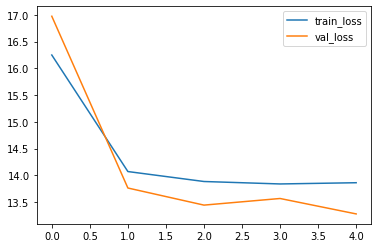

In [43]:
loss_train=lossmean(epoch_loss,8921)
loss_val=lossmean(epochval_loss,991)
plt.plot(range(5),loss_train,label="train_loss")
plt.plot(range(5),loss_val,label="val_loss")
plt.legend()

In [44]:
_,featuremap=model()

WangNet(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2

In [35]:
out,fea=model(x_grad)

In [70]:
fea[0].shape
fea=fea.view(-1,512*7*7)

In [72]:
zz=fea.retain_grad()

In [80]:
x11=model.block5(fea)
x11[0].backward(retain_graph=True) 

RuntimeError: Trying to backward through the graph a second time (or directly access saved variables after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved variables after calling backward.

In [158]:
nn=fea.grad

In [159]:
aa=nn.reshape(32,512,7,7)

In [117]:
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing import image

In [145]:
fea_grad=tf.convert_to_tensor(np.transpose(aa[0],(1,2,0)))

In [146]:
fea_grad=tf.reshape(fea_grad,[1,7,7,512])

In [147]:
pool_grad=tf.reduce_mean(fea_grad, axis=(0, 1, 2))

In [190]:
heatmap= tf.reduce_mean(tf.multiply(pool_grad, fea[4].detach().numpy().reshape(7,7,512)), axis=-1)

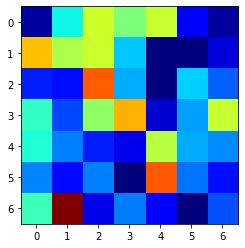

In [191]:
heatmap = heatmap.numpy()
heatmap[heatmap < 0] = 0 #relu
heatmap = (heatmap - heatmap.min())/(heatmap.max() - heatmap.min())
heatmap = heatmap.reshape((7, 7))

# We plot the (7,7) heatmap
plt.imshow(heatmap,cmap='jet')
plt.show()

In [192]:
resized_heatmap = np.uint8(cv2.resize(heatmap,(256,256))*255)

In [193]:
val = np.uint8(256-resized_heatmap)
heatmap_final = cv2.applyColorMap(val, cv2.COLORMAP_JET)

In [194]:
img = image.img_to_array(np.transpose(x_grad[4]*255,(1,2,0)))
img = np.uint8(img)

In [195]:
heatmap_final.shape

(256, 256, 3)

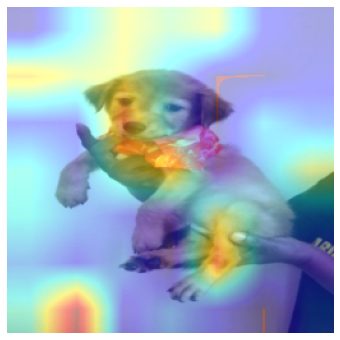

In [196]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.imshow(cv2.addWeighted(heatmap_final, 0.4, img, 0.7, 0))
ax.axis('off');
plt.show();

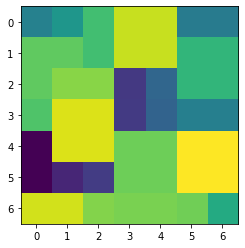

In [50]:
plt.imshow(fea[1][10].detach().numpy())

In [25]:
from torch.autograd import Variable

In [17]:
model=torch.load('WangM5V1val.pth',map_location='cpu')

In [18]:
x_grad,y_grad= next(iter(train_loader))
x_grad=x_grad[0]

In [27]:
out,fea=model(x_grad)
fea_in=Variable(fea,requires_grad=True)

In [30]:
grad_c=torch.autograd.grad(out[0],fea_in,allow_unused=True)

In [32]:
grad_c

(None,)

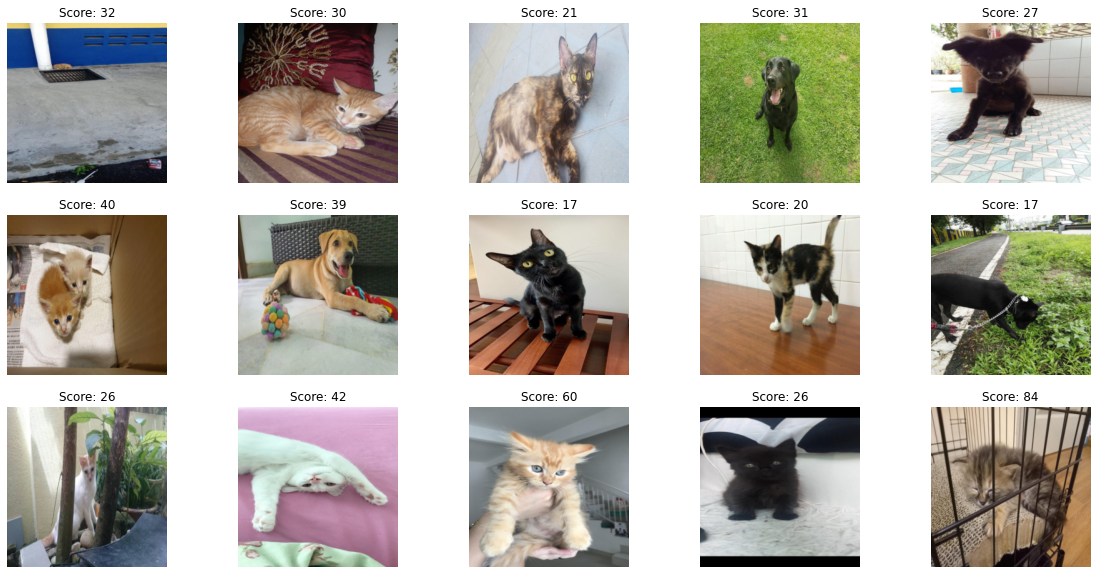

In [38]:
fig, ax = plt.subplots(3,5,figsize=(20,10))
count=0
for i in range(3):
    for j in range(5):
        ax[i][j].imshow(np.transpose(x_grad[count], (1, 2, 0)))
        ax[i][j].axis('off')
        label = y_grad[count]
        ax[i][j].set_title(f'Score: {label}')
        count+=1  